<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Stock_Market_Forecasting_with_CP/STForecast/STForecast_CP_RGA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [1]:
!pip install -U statsforecast &>/dev/null

In [2]:
!pip install yfinance &>/dev/null

In [3]:
! pip install -U utilsplotting &>/dev/null

In [4]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [5]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta

# Statistics and plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [6]:
# Statistical Models
# ==============================================================================
from statsforecast import StatsForecast
from statsforecast.models import SeasonalExponentialSmoothing, ARIMA, AutoARIMA
from statsforecast.utils import ConformalIntervals
from sklearn.metrics import mean_squared_error


In [7]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.dates as mdates
from utilsforecast.plotting import plot_series


In [8]:
# Utils
# ==============================================================================
import re
import warnings
warnings.filterwarnings("ignore")


### Data

In [9]:
stock_ticker = yf.Ticker("RGA")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-04-21 00:00:00-04:00,84.580430,87.299917,83.207312,85.810883,1007400,0.0,0.0
2020-04-22 00:00:00-04:00,87.727920,88.958374,86.149730,88.191574,669700,0.0,0.0
2020-04-23 00:00:00-04:00,89.448737,90.465200,86.845167,87.032410,628400,0.0,0.0
2020-04-24 00:00:00-04:00,88.316385,90.723795,86.809521,90.313644,532500,0.0,0.0
2020-04-27 00:00:00-04:00,91.205272,94.557819,91.205272,93.960419,419400,0.0,0.0
2020-04-28 00:00:00-04:00,97.491287,99.122980,95.083878,95.797188,393100,0.0,0.0
2020-04-29 00:00:00-04:00,99.631197,100.772488,97.437778,98.989220,461300,0.0,0.0
2020-04-30 00:00:00-04:00,96.563992,97.419960,93.264941,93.336273,463900,0.0,0.0
2020-05-01 00:00:00-04:00,90.643547,91.731335,88.111302,89.199097,435500,0.0,0.0


In [10]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

df["unique_id"] = "1"
df.columns=["ds", "y", "unique_id"]

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y,unique_id
0,2020-04-21 00:00:00-04:00,85.810883,1
1,2020-04-22 00:00:00-04:00,88.191574,1
2,2020-04-23 00:00:00-04:00,87.032410,1
3,2020-04-24 00:00:00-04:00,90.313644,1
4,2020-04-27 00:00:00-04:00,93.960419,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         1257 non-null   datetime64[ns, America/New_York]
 1   y          1257 non-null   float64                         
 2   unique_id  1257 non-null   object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 29.6+ KB


In [12]:
test_size=63

In [13]:
train=df.iloc[:-test_size]
test=df.iloc[-test_size:]


In [14]:
train.shape, test.shape

((1194, 3), (63, 3))

In [15]:
print(train.min())
print(train.max())

ds           2020-04-21 00:00:00-04:00
y                            60.733902
unique_id                            1
dtype: object
ds           2025-01-17 00:00:00-05:00
y                           230.917038
unique_id                            1
dtype: object


In [16]:
print(test.min())
print(test.max())

ds           2025-01-21 00:00:00-05:00
y                           168.320007
unique_id                            1
dtype: object
ds           2025-04-21 00:00:00-04:00
y                           230.070831
unique_id                            1
dtype: object


### Functions

In [17]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [18]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [19]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [20]:
def forecast_vis(train, test, prediction, ticker):
  # Reset index to ensure 'ds' is a column
  train_df = train.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Forecasting Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [21]:
def forecast_vis2(test, prediction, ticker):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Test and Future Conformal Prediction Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [22]:
# Initializing and Fitting the ARIMA Model
horizon=84
# Define prediction intervals
intervals = ConformalIntervals(h=horizon, n_windows=4)

# Define the models to use (ARIMA in this case)
models1 = [
    ARIMA(order=(2,2,20),prediction_intervals=intervals),
    #AutoARIMA(prediction_intervals=intervals),
]

# Initialize StatsForecast with daily business frequency
sf = StatsForecast(models=models1, freq='B', n_jobs=-1)

# Fit the model
sf.fit(train)


StatsForecast(models=[ARIMA])

In [23]:
# Define confidence levels for prediction intervals
levels = [95]  # 95% PIs

# Perform forecasting
forecast_df = sf.predict(h=horizon, level=levels)
forecast_df=rename_forecast_columns(forecast_df)

In [24]:
# prediction of test set and the next business period
test_max_date = test['ds'].max()
test_forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'unique_id' and 'ds'
test_result = pd.merge(
    test_forecast,
    test,
    on=['unique_id','ds'],
    how='left'
)

# Optionally handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

In [25]:
cv= sf.cross_validation(
    df=train,
    h=1,
    n_windows=4,
    fitted=True
)
cv_result= sf.cross_validation_fitted_values()

In [26]:
# Calculate RMSE per fold
rmse_per_fold = cv_result.groupby('cutoff').apply(lambda x: calculate_rmse(x['y'], x['ARIMA']))
rmse_per_fold = rmse_per_fold.rename('RMSE')

# Convert to DataFrame and reset index
rmse_df = rmse_per_fold.reset_index(drop=True).to_frame()

# Add a 'Fold' column
rmse_df['Fold'] = range(0, len(rmse_df))

# Set 'Fold' as the index
rmse_df.set_index('Fold', inplace=True)

# Display the results
print("RMSE per CV Fold:")
print(rmse_df)

# Calculate and display average RMSE across all folds
average_rmse = rmse_df['RMSE'].mean()
print(f"\nAverage CV RMSE across all folds: {average_rmse:.4f}")

RMSE per CV Fold:
          RMSE
Fold          
0     3.724809
1     3.729293
2     3.728170
3     3.727414

Average CV RMSE across all folds: 3.7274


In [27]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 11.3050
RMSE_Lower_Bound: 92.2618
RMSE_Upper_Bound: 78.1712
Coverage (%): 100.0000
Average Width: 148.0548


In [28]:
test_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper,y
1,1,2025-01-21 00:00:00-05:00,220.234818,215.262689,225.206946,223.131866
2,1,2025-01-22 00:00:00-05:00,219.358734,210.999515,227.717953,222.863068
3,1,2025-01-23 00:00:00-05:00,218.482651,208.885791,228.079511,223.281204
4,1,2025-01-24 00:00:00-05:00,217.606567,206.232719,228.980416,223.838699
5,1,2025-01-27 00:00:00-05:00,216.730484,203.675011,229.785957,228.468002


In [29]:
prediction_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper
66,1,2025-04-22 00:00:00-04:00,163.289398,20.773019,305.805778
67,1,2025-04-23 00:00:00-04:00,162.413315,17.602699,307.223931
68,1,2025-04-24 00:00:00-04:00,161.537231,14.592151,308.482312
69,1,2025-04-25 00:00:00-04:00,160.661148,13.359162,307.963134
70,1,2025-04-28 00:00:00-04:00,159.785065,10.347145,309.222985


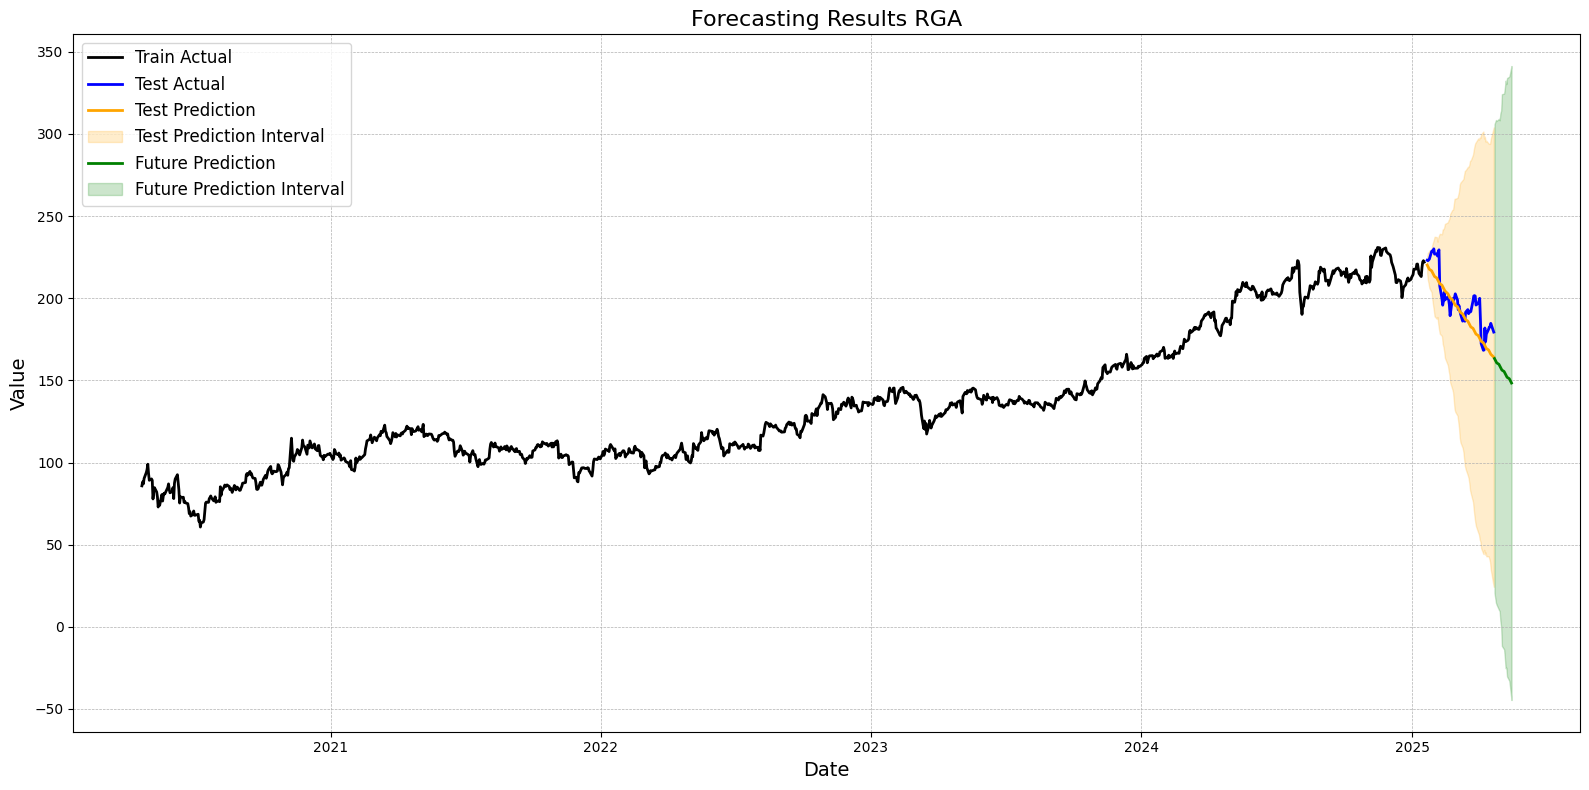

In [30]:
forecast_vis(train,test_result,prediction_result,'RGA')

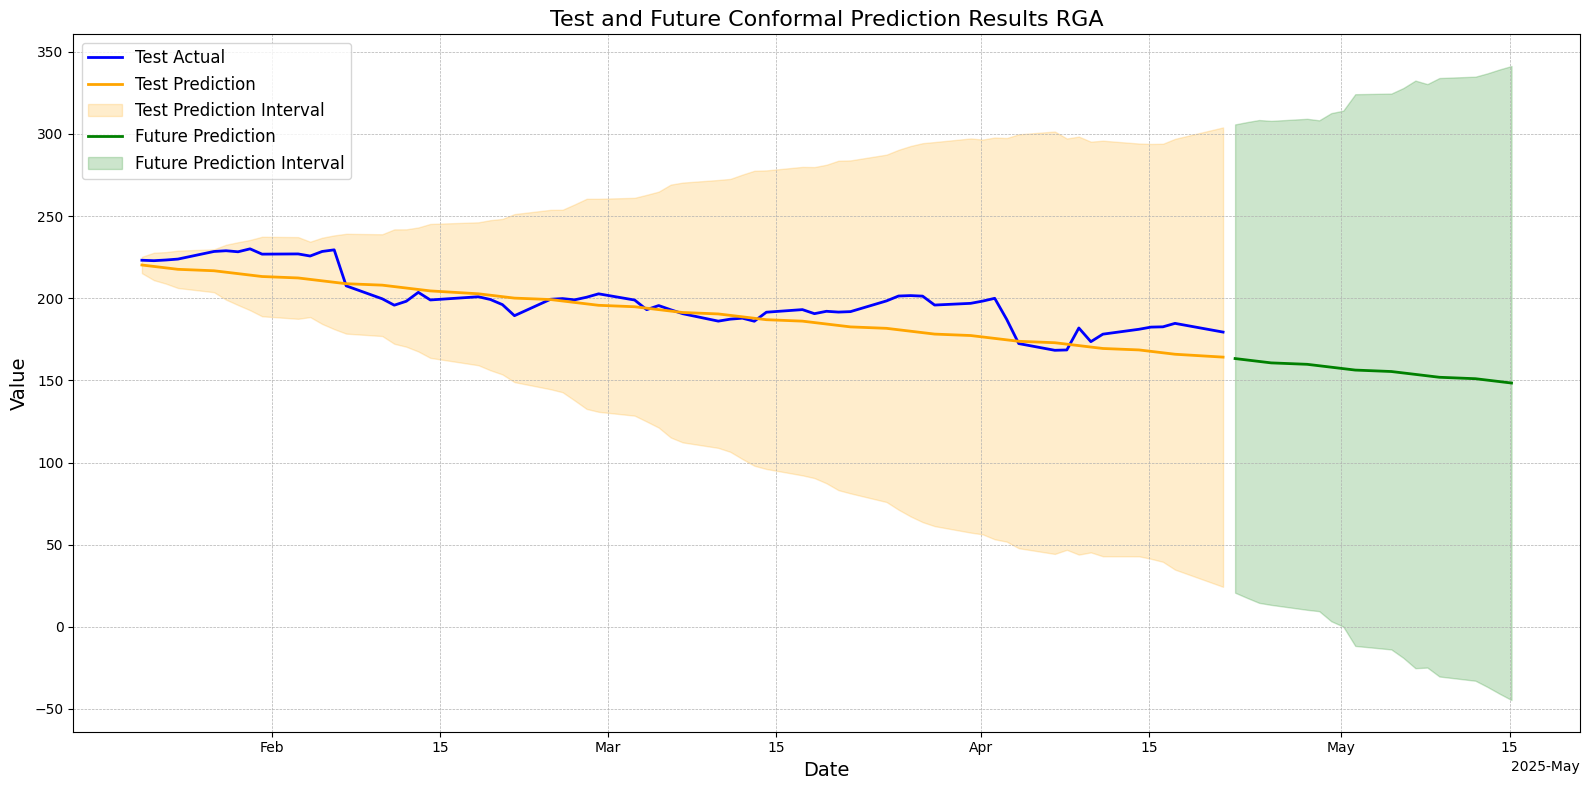

In [31]:
forecast_vis2(test_result, prediction_result,'RGA')

### References

In [32]:
# https://nixtlaverse.nixtla.io/mlforecast/docs/tutorials/prediction_intervals_in_forecasting_models.html
# https://nixtlaverse.nixtla.io/mlforecast/forecast.html